In [1]:
from sklearn.datasets import make_swiss_roll
import matplotlib.pyplot as plt
import torch
from torch import optim
import torch.nn.functional as F
from torch import nn
from tqdm import tqdm

/home/hun/workspace/.venv/tts/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DEVICE = "cpu"

BETA_STARTS = 1e-4
BETA_ENDS = 0.02
N_SAMPLES = 2**13
N_STEPS = 100

BATCH_SIZE = 32
N_EPOCHS = 1000

In [3]:
def sample_from_swiss_roll(n_samples):
    data, _ = make_swiss_roll(n_samples=n_samples, noise=0.5)
    return torch.Tensor(data[:, [0, 2]] / 10).to(DEVICE)

torch.Size([8192, 2])


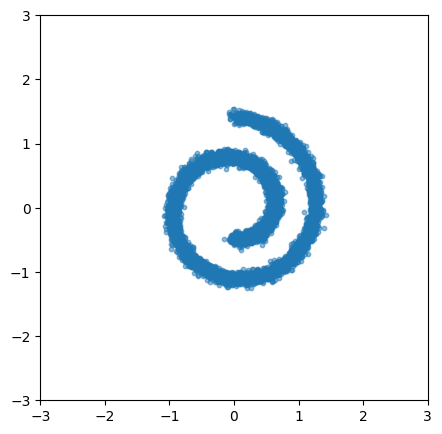

In [4]:
x_0 = sample_from_swiss_roll(N_SAMPLES)
print(x_0.shape)

plt.figure(figsize=(5, 5))
plt.scatter(*x_0.cpu().T, alpha=0.5, s=10)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.show()

In [5]:
def get_beta(start, end, n_steps, t):
    x = (end - start) / (n_steps - 1)
    beta_t = start + x * t
    return beta_t


def get_betas(start, end, n_steps):
    betas = [get_beta(start, end, n_steps, t) for t in range(n_steps)]
    return torch.Tensor(betas).to(DEVICE)  # 1 ~ T, len: T


def forward_step(x_0, betas):
    x_seq = [x_0]
    for t in range(1, len(betas) + 1):
        x_t_minus_1 = x_seq[-1]
        beta_t = betas[t - 1]
        epsilon = torch.randn_like(x_0)
        x_t = torch.sqrt(1 - beta_t) * x_t_minus_1 + torch.sqrt(beta_t) * epsilon
        x_seq.append(x_t)

    return x_seq  # 0 ~ T, len: T+1

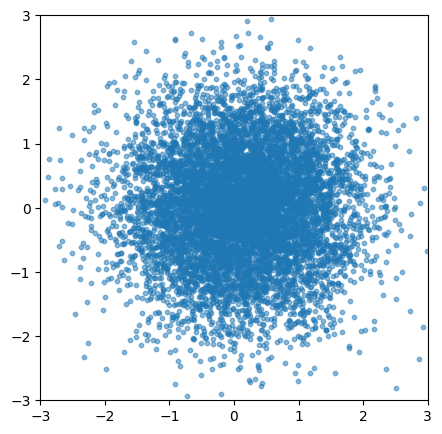

In [6]:
betas = get_betas(BETA_STARTS, BETA_ENDS, N_STEPS).to(DEVICE)
diffusion_result = forward_step(x_0, betas)

plt.figure(figsize=(5, 5))
plt.scatter(*diffusion_result[N_STEPS].cpu().T, alpha=0.5, s=10)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.show()

In [7]:
def get_alphas(betas):
    alphas = 1 - betas
    alpha_bars = torch.cumprod(alphas, 0)
    return alphas, alpha_bars  # 1 ~ T, len: T


def get_x_t_given_x_0(x_0, t, alpha_bars):
    # t must be in [1, T], if t = 0, then x_t = x_0
    alpha_bar_t = alpha_bars[t - 1]
    alpha_bar_t = alpha_bar_t.view(-1, 1)
    noise = torch.randn_like(x_0)
    x_t = torch.sqrt(alpha_bar_t) * x_0 + torch.sqrt(1 - alpha_bar_t) * noise
    return x_t

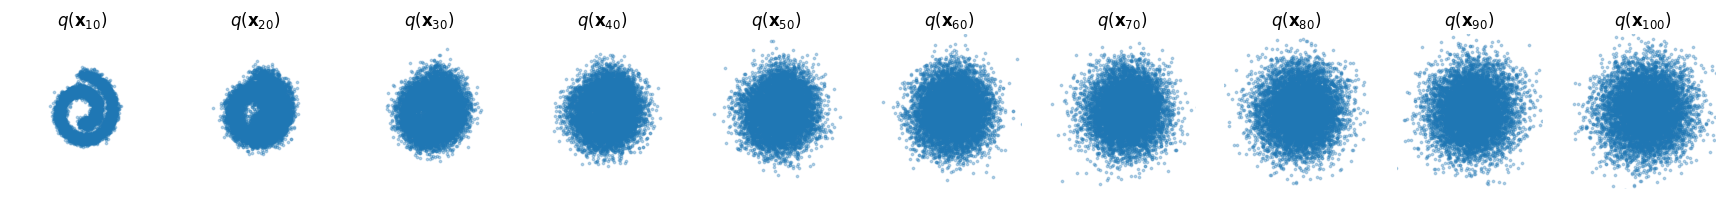

In [8]:
fig, ax = plt.subplots(1, 10, figsize=(22, 2))

for i in range(10):
    t = int((i + 1) * N_STEPS / 10)

    alphas, alpha_bars = get_alphas(betas)
    x_t = get_x_t_given_x_0(x_0, t, alpha_bars)

    ax[i].scatter(*x_t.cpu().T, alpha=0.3, s=3)
    ax[i].set_xlim(-3, 3)
    ax[i].set_ylim(-3, 3)
    ax[i].set_axis_off()
    ax[i].set_title("$q(\mathbf{x}_{" + str(t) + "})$")
plt.show()

In [9]:
class ConditionalLinear(nn.Module):
    def __init__(self, num_in, num_out, n_steps):
        super(ConditionalLinear, self).__init__()
        self.num_out = num_out
        self.lin = nn.Linear(num_in, num_out)
        self.embed = nn.Embedding(n_steps, num_out)  # 1 ~ T
        self.embed.weight.data.uniform_()

    def forward(self, x_t, t):
        out = self.lin(x_t)
        gamma = self.embed(t)
        out = gamma.view(-1, self.num_out) * out
        return out


class TConditionalModel(nn.Module):
    def __init__(self, n_steps):
        super().__init__()
        self.lin1 = ConditionalLinear(2, 128, n_steps)
        self.lin2 = ConditionalLinear(128, 128, n_steps)
        self.lin3 = ConditionalLinear(128, 128, n_steps)
        self.lin4 = nn.Linear(128, 2)

    def forward(self, x_t, t):
        x_t = F.softplus(self.lin1(x_t, t))
        x_t = F.softplus(self.lin2(x_t, t))
        x_t = F.softplus(self.lin3(x_t, t))
        return self.lin4(x_t)

In [10]:
model = TConditionalModel(N_STEPS)
model

TConditionalModel(
  (lin1): ConditionalLinear(
    (lin): Linear(in_features=2, out_features=128, bias=True)
    (embed): Embedding(100, 128)
  )
  (lin2): ConditionalLinear(
    (lin): Linear(in_features=128, out_features=128, bias=True)
    (embed): Embedding(100, 128)
  )
  (lin3): ConditionalLinear(
    (lin): Linear(in_features=128, out_features=128, bias=True)
    (embed): Embedding(100, 128)
  )
  (lin4): Linear(in_features=128, out_features=2, bias=True)
)

In [11]:
def p_sample(x_t, model, t_minus_1, betas, alphas, alpha_bars):
    beta_t = betas[t_minus_1]
    alpha_t = alphas[t_minus_1]
    alpha_bar_t = alpha_bars[t_minus_1]
    alpha_bar_t_minus_1 = alpha_bars[torch.clamp_min(t_minus_1 - 1, 0)]  # exception for t=1 (t_minus_1=0)

    mean = 1 / alpha_t.sqrt() * (x_t - beta_t / (1 - alpha_bar_t).sqrt() * model(x_t, t_minus_1))
    std = ((1 - alpha_bar_t_minus_1) / (1 - alpha_bar_t) * beta_t).sqrt()
    z = torch.randn_like(x_t).to(DEVICE)

    x_t_minus_1 = mean + std * z

    return x_t_minus_1


def p_sample_loop(shape, model, betas, alphas, alpha_bars):
    x_T = torch.randn(shape, device=DEVICE)
    x_seq = [x_T]
    for t_minus_1 in reversed(range(N_STEPS)):
        x_t = x_seq[-1]
        t_minus_1 = torch.LongTensor([t_minus_1]).to(DEVICE)
        x_t_minus_1 = p_sample(x_t, model, t_minus_1, betas, alphas, alpha_bars)
        x_seq.append(x_t_minus_1)
    return x_seq  # len: T+1

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 1, Loss: 0.7739274501800537


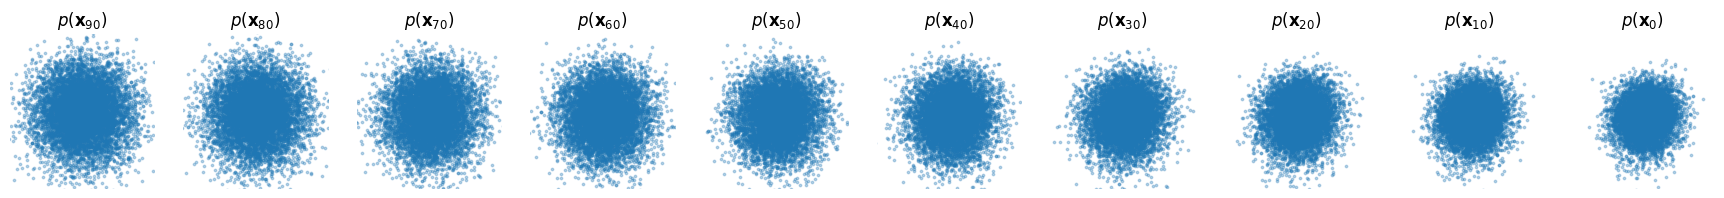

 20%|█▉        | 199/1000 [01:56<07:41,  1.73it/s]

Epoch: 200, Loss: 0.4431685209274292


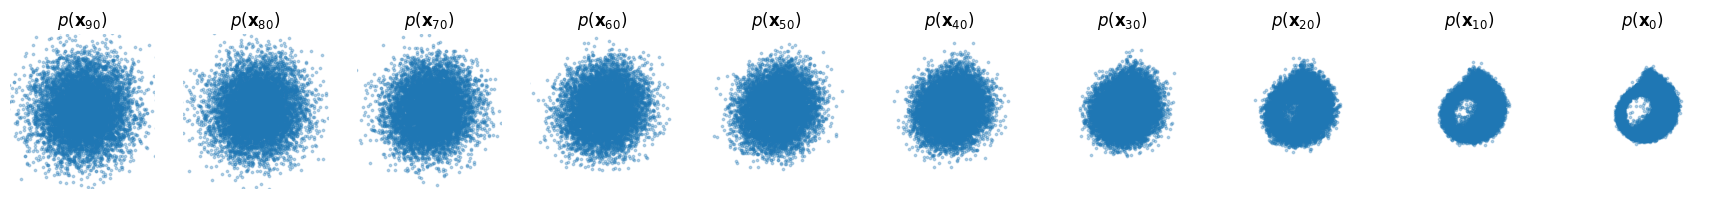

 40%|███▉      | 399/1000 [03:56<05:48,  1.72it/s]

Epoch: 400, Loss: 0.5031515955924988


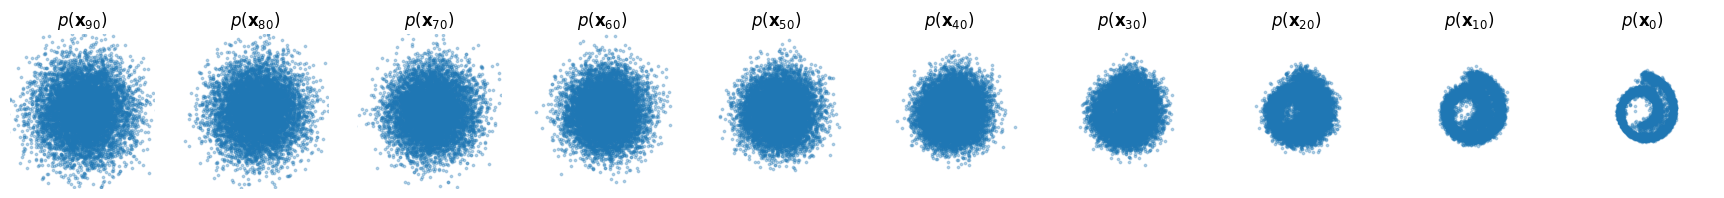

 60%|█████▉    | 599/1000 [06:10<04:41,  1.42it/s]

Epoch: 600, Loss: 0.30554482340812683


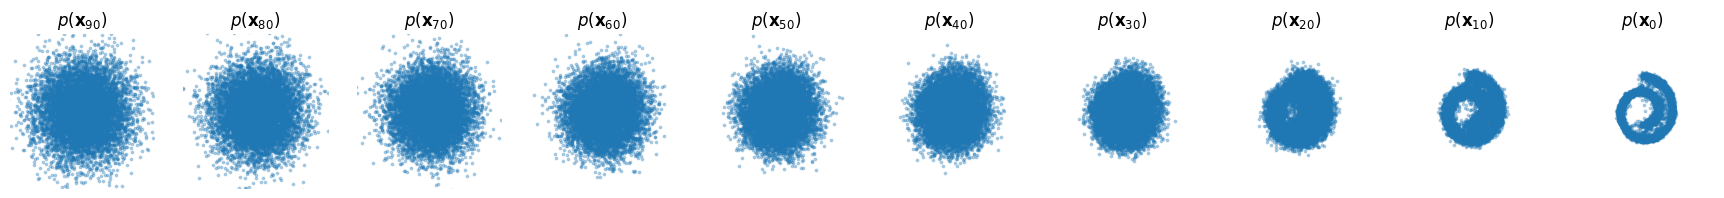

 80%|███████▉  | 799/1000 [08:38<02:53,  1.16it/s]

Epoch: 800, Loss: 0.7474233508110046


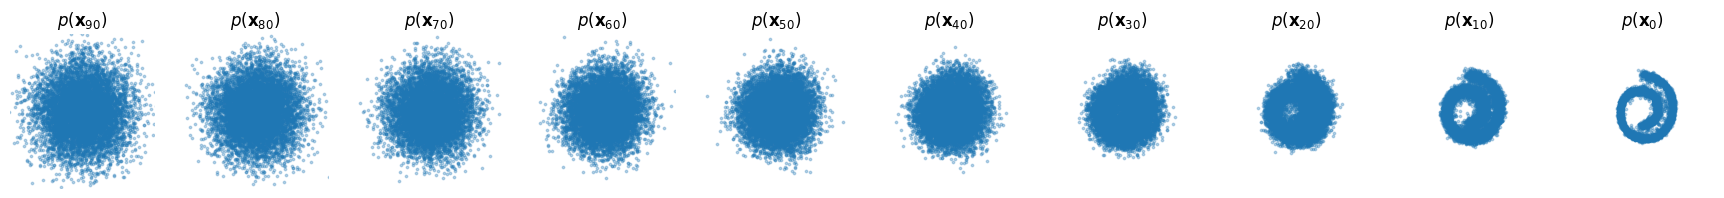

100%|█████████▉| 999/1000 [11:28<00:01,  1.23s/it]

Epoch: 1000, Loss: 0.46550798416137695


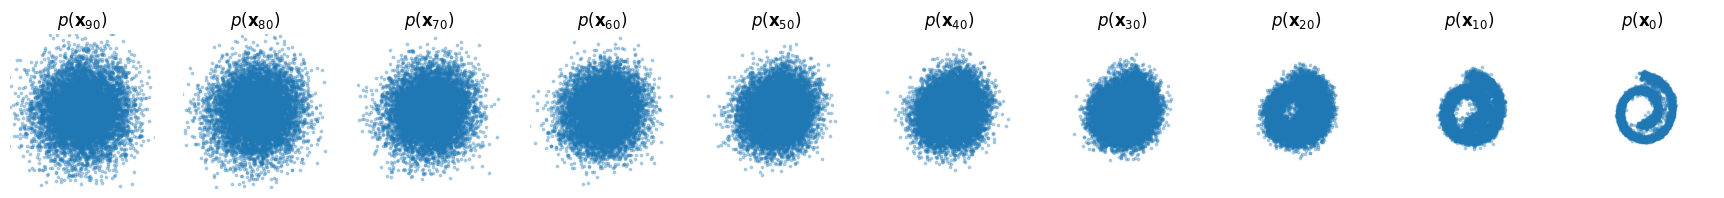

100%|██████████| 1000/1000 [11:34<00:00,  1.44it/s]


In [12]:
model = TConditionalModel(N_STEPS).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
x_0 = sample_from_swiss_roll(N_SAMPLES)
betas = get_betas(BETA_STARTS, BETA_ENDS, N_STEPS)
alphas, alpha_bars = get_alphas(betas)

for epoch_idx in tqdm(range(N_EPOCHS)):
    # shuffle
    permutation = torch.randperm(x_0.size(0))

    # train batch
    for batch_idx in range(0, x_0.size(0), BATCH_SIZE):
        indices = permutation[batch_idx : batch_idx + BATCH_SIZE]
        batch = x_0[indices]
        epsilon = torch.randn_like(batch).to(DEVICE)

        t = torch.randint(1, N_STEPS + 1, size=(BATCH_SIZE,), device=DEVICE)

        x_t = alpha_bars[t - 1].sqrt().view(-1, 1) * batch + (1 - alpha_bars[t - 1]).sqrt().view(-1, 1) * epsilon
        epsilon_theta = model(x_t, t - 1)

        loss = (epsilon - epsilon_theta).square().mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # evaluate
    if epoch_idx == 0 or (epoch_idx + 1) % 200 == 0:
        print(f"Epoch: {epoch_idx + 1}, Loss: {loss.item()}")
        x_seq = p_sample_loop(x_0.size(), model, betas, alphas, alpha_bars)
        fig, ax = plt.subplots(1, 10, figsize=(22, 2))
        for i in range(10):
            t = int((i + 1) * N_STEPS / 10)
            x_t = x_seq[t].detach().cpu()
            ax[i].scatter(*x_t.T, alpha=0.3, s=3)
            ax[i].set_xlim(-3, 3)
            ax[i].set_ylim(-3, 3)
            ax[i].set_axis_off()
            ax[i].set_title("$p(\mathbf{x}_{" + str(N_STEPS - t) + "})$")
        plt.show()